In [1]:
import os
import random

import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
TRAIN_DATA_PATH = 'data/train.csv'
TEST_DATA_PATH = 'data/test.csv'

TRAIN_DIRECTORY = 'data/train'
TEST_DIRECTORY = 'data/test'

In [3]:
TARGET_NAME = 'Pawpularity'
VAL_SIZE = 0.15
SEED = 5

In [4]:
# Train data set
data_train = pd.read_csv(TRAIN_DATA_PATH)
print(f'Train data shape: {data_train.shape}')
data_train.head()

Train data shape: (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [28]:
import cv2

def read_image(filename):
    filepath = os.path.join(TRAIN_DIRECTORY, filename+".jpg")
    img=cv2.imread(filepath)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [26]:
def get_images(field_name, title1, title2, rand_state=10):
    print(field_name)
    imgs1=data_train[data_train[field_name] == 0].sample(5, random_state=rand_state).Id.values
    imgs2=data_train[data_train[field_name] == 1].sample(5, random_state=rand_state).Id.values
    
    imgs=np.concatenate([imgs1, imgs2])
    imgs=[read_image(imgname) for imgname in imgs]
    
    _, ax=plt.subplots(2, 5, figsize=(17, 8), sharex=True, sharey=True)

    ax[0, 0].set_title(title1)
    ax[1, 0].set_title("\n"+title2)
    for i in range(2):
        for j in range(5):
            ax[i, j].imshow( imgs[i*5 + j] )
    plt.title(field_name)
    plt.show()

Subject Focus


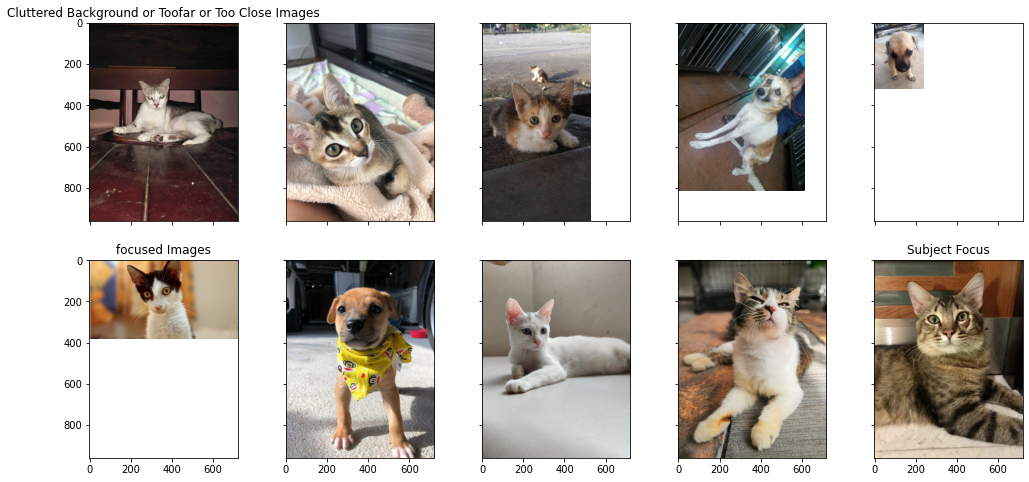

In [30]:
get_images("Subject Focus", "Cluttered Background or Toofar or Too Close Images", "focused Images", rand_state=10)

### First baseline with RandomForest on tabular features

In [53]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor

y_log = np.log1p(data_train[TARGET_NAME])
x = data_train[[cols for cols in data_train.columns if cols not in [TARGET_NAME,'Id']]]
fold=KFold(n_splits=5,random_state=42,shuffle=True)
X_train,X_test,y_train,y_test=train_test_split(x,y_log,random_state=42,test_size=0.2)

In [54]:
param={'n_estimators' : [600,800,900,1000,1100,1200],
      'max_depth': [2,3,5,7]}

forest_reg=RandomForestRegressor(random_state=42)
forest_reg_grid=GridSearchCV(forest_reg,param,n_jobs=-1,cv=fold)
forest_reg_grid.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7],
                         'n_estimators': [600, 800, 900, 1000, 1100, 1200]})

In [55]:
print(forest_reg_grid.best_params_)
forest_reg_final=RandomForestRegressor(**forest_reg_grid.best_params_,random_state=42)
forest_reg_final=forest_reg_final.fit(X_train,y_train)

{'max_depth': 3, 'n_estimators': 1200}


In [56]:
y_pred=forest_reg_final.predict(X_test)

In [57]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,y_pred)
rmse=np.sqrt(mse)
rmse

0.5860997833660625